In [375]:
%matplotlib inline

In [376]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [377]:
# Note: Values of -4, -3, -2, -1 indicate variable, blank, don't know or refused therefore convert to NaN
na_values = [-4, -3, -2, -1]

In [378]:
# Import summary csv to df (basic summary of activity times (each activity has a separate column))
dfsum = pd.read_csv("data/atussum_0315/atussum_0315.csv",
                    index_col=False,
                    na_values=na_values)

In [379]:
# Import roster csv to df (includes line numbers for each person in a household)
dfrost = pd.read_csv("data/atusrost_0315/atusrost_0315.csv",
                     index_col=False,
                     na_values=na_values)

In [380]:
# Import respondent csv to df (more info on the respondent of the survey (i.e. TULINENO = 1))
dfresp = pd.read_csv("data/atusresp_0315/atusresp_0315.csv",
                     index_col=False,
                     na_values=na_values)

In [381]:
# Import activity csv to df
dfact = pd.read_csv("data/atusact_0315/atusact_0315.csv",
                    index_col=False,
                    na_values=na_values)

In [382]:
# Import activity code dictionary csv to df
dfactcodes = pd.read_csv("data/activity_codes.csv",
                         index_col=False,
                         sep=';',
                         dtype={'CODE': str, 'NAME': str})

In [383]:
# Import education level code dictionary csv to df
dfeducodes = pd.read_csv("data/edu_codes.csv",
                         index_col=False,
                         sep=';',
                         dtype={'CODE': str, 'NAME': str})

In [384]:
# Import occupation and industry code dictionary csv to df
dfindocc = pd.read_csv("data/indocc_codes.csv",
                       index_col=False,
                       sep=';',
                       dtype={'FLAG': str, 'CODE': str, 'NAME': str})

In [385]:
#dfsum[['TUCASEID', 'TEAGE', 'TESEX', 'TUFNWGTP', 'PEEDUCA', 't010201']].head()

In [386]:
#dfrost.head()

In [387]:
#dfresp[['TUCASEID', 'TRMJOCGR', 'TRDTOCC1', 'TRMJIND1']].head()

In [388]:
#dfact.head()

In [389]:
# Add codepoint level (1, 2 or 3) and sort
dfactcodes['LEVEL'] = dfactcodes.CODE.str.len() / 2
dfactcodes = dfactcodes.sort_values('CODE').reset_index(drop=True)

In [390]:
#dfeducodes

In [391]:
#dfindocc.head()

In [392]:
# Merge datasets by TUCASEID
dfmerged = pd.merge(dfsum,
                    dfresp[['TUCASEID', 'TRMJOCGR', 'TRDTOCC1', 'TRMJIND1', 'TUFWK', 'TEIO1COW']],
                    on='TUCASEID',
                    how='left',
                    copy=False)

In [393]:
# Multiply activity times and other variables by weights (TUFNWGTP) to allow for sampling biases
var_keys = dfmerged.keys()[24:455].tolist() + ['TEHRUSLT', 'TEAGE', 'TRERNWA', 'TRYHHCHILD', 'TRCHILDNUM']

dfmerged_w = dfmerged.join(dfmerged[var_keys].multiply(dfmerged.TUFNWGTP, axis='index'),
                           how='left',
                           rsuffix='_W')

# Add weighted activity columns in same group (level 1 and 2)
dfmerged_w_copy = dfmerged_w.copy()
for c in dfactcodes[dfactcodes.LEVEL == 2].CODE.values:
    dfmerged_w_copy['t' + c + '_W'] = dfmerged_w.filter(like='t' + c).filter(like='_W').sum(axis='columns')
for c in dfactcodes[dfactcodes.LEVEL == 1].CODE.values:
    dfmerged_w_copy['t' + c + '_W'] = dfmerged_w.filter(like='t' + c).filter(like='_W').sum(axis='columns')
dfmerged_w = dfmerged_w_copy

In [394]:
# Group by education level and age > 18
dfmerged_w_byedu = dfmerged_w[dfmerged_w.TEAGE > 18].groupby('PEEDUCA')

In [395]:
# Calculate averages weighted correctly
a = dfmerged_w_byedu.sum().filter(like='_W').filter(like='t').divide(dfmerged_w_byedu.TUFNWGTP.sum(), axis='index')

In [396]:
# Average minutes per day on a particular activity (across all groups)
sum_of_weights = dfmerged_w[dfmerged_w.TEAGE > 18].TUFNWGTP.sum()
a_mean = dfmerged_w[dfmerged_w.TEAGE > 18].filter(like='_W').filter(like='t').sum() / sum_of_weights

In [397]:
# Deviation of Average minutes per day by group from Average for all groups
a_fraction = a.divide(a_mean) - 1.0

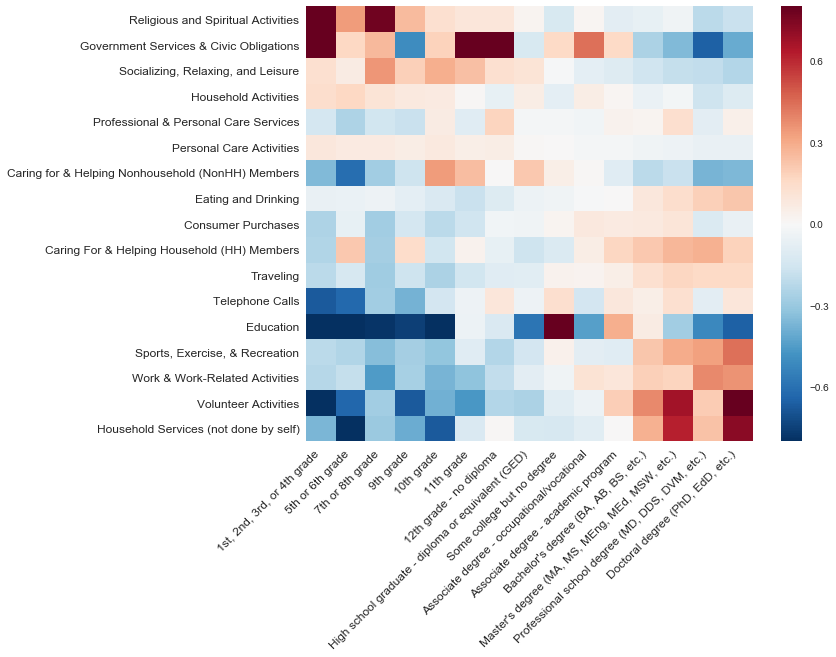

In [398]:
# Setup plot data df
plotdf1 = a_fraction.iloc[:,533:-1].T

# Create order by ranking education level from -1 to +1
plotdf1['order'] = plotdf1.multiply(np.linspace(-1,1,num=16)).sum(axis='columns')

# Add activity names
plotdf1['name'] = dfactcodes[dfactcodes.LEVEL == 1].NAME.values[:-1]

# Plot heatmap
plt.figure(figsize=(10, 8))
p = sns.heatmap(plotdf1.sort_values('order').iloc[:,1:-2], vmin=-0.8, vmax=0.8)
p.set_yticklabels(plotdf1.sort_values('order', ascending=False).name,
                 rotation=0,
                 fontsize=12)
p.set_xticklabels(dfeducodes.NAME.values[1:],
                  rotation=45,
                  ha='right',
                  fontsize=12)
p.set(xlabel='')
plt.savefig('fig01.svg', bbox_inches='tight')
plt.show()

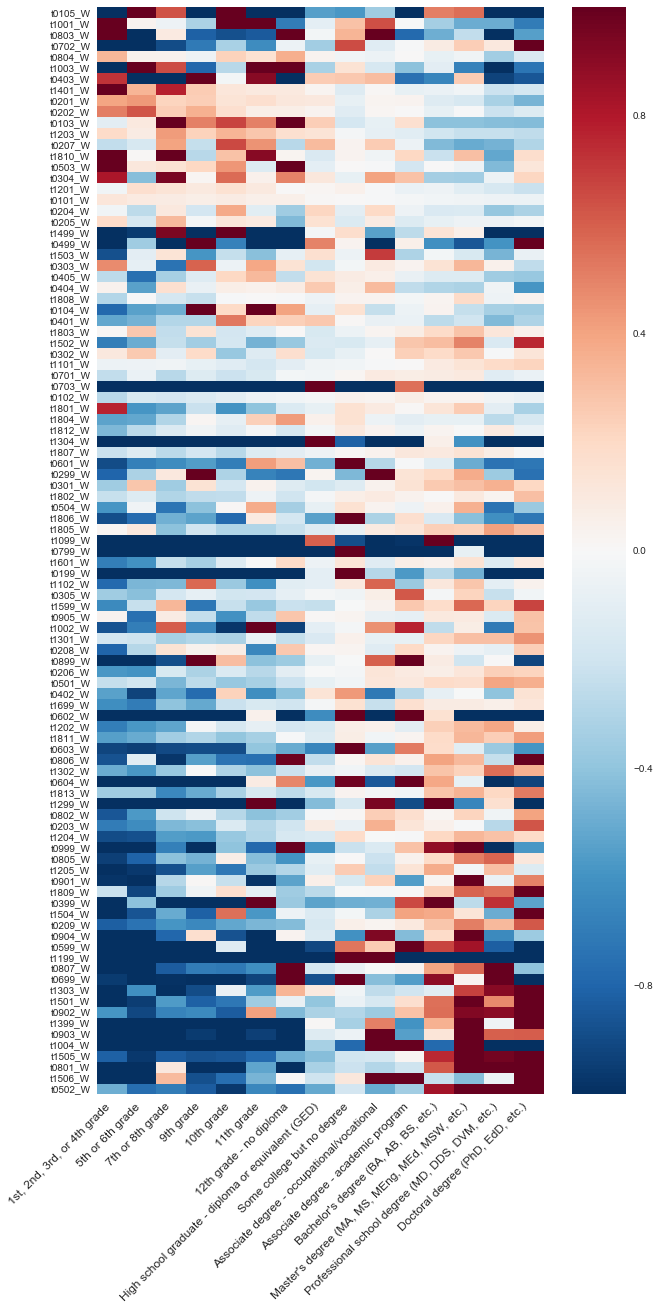

In [399]:
# Setup plot data df
plotdf2 = a_fraction.iloc[:,431:531].T

# Create order by ranking education level from -1 to +1
plotdf2['order'] = plotdf2.multiply(np.linspace(-1,1,num=16)).sum(axis='columns')

# Add activity names
plotdf2['name'] = dfactcodes[dfactcodes.LEVEL == 2].NAME.values[:-2]

# Plot heatmap
plt.figure(figsize=(10, 20))
p = sns.heatmap(plotdf2.sort_values('order').iloc[:-1,1:-2], vmin=-1.0, vmax=0.8)
p.set_xticklabels(dfeducodes.NAME.values[1:],
                  rotation=45,
                  ha='right',
                  fontsize=12)
p.set(xlabel='')
plt.savefig('fig02.svg', bbox_inches='tight')
plt.show()

In [400]:
# Details of selected Activities as a function of work
test_activities = ['t010101_W', 't010201_W', 't120101_W', 't120303_W']

In [401]:
# Group by age and age > 18 
dfmerged_w_byage = dfmerged_w[dfmerged_w.TEAGE > 18].groupby('TEAGE')

# Group by year and age > 18
#dfmerged_w_byinc = dfmerged_w[dfmerged_w.TEAGE > 18].groupby('TUYEAR')

In [402]:
# Calculate averages weighted correctly
keys_w = dfmerged_w.keys().values[460:]
a1 = dfmerged_w_byage[keys_w].sum().divide(dfmerged_w_byage.TUFNWGTP.sum(), axis='index').reset_index()
a2 = dfmerged_w_byedu[keys_w].sum().divide(dfmerged_w_byedu.TUFNWGTP.sum(), axis='index').reset_index()
#a3 = dfmerged_w_byinc[keys_w].sum().divide(dfmerged_w_byinc.TUFNWGTP.sum(), axis='index').reset_index()

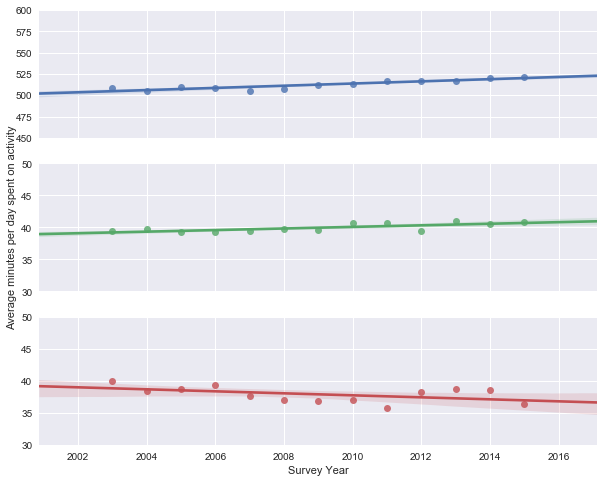

In [418]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))
sns.regplot(x='TUYEAR', y='t010101_W', data=a3, order=1, ax=ax1)
sns.regplot(x='TUYEAR', y='t010201_W', data=a3, order=1, ax=ax2)
sns.regplot(x='TUYEAR', y='t120101_W', data=a3, order=1, ax=ax3)
ax1.set(ylim=[450,600], ylabel='', xlabel='')
ax2.set(ylim=[30,50], ylabel='Average minutes per day spent on activity', xlabel='')
ax3.set(ylim=[30,50], ylabel='', xlabel='Survey Year')
plt.savefig('fig05.svg', bbox_inches='tight')

In [406]:
dfeducodes.NAME.values[1::2]

array(['1st, 2nd, 3rd, or 4th grade', '7th or 8th grade', '10th grade',
       '12th grade - no diploma', 'Some college but no degree',
       'Associate degree - academic program',
       "Master's degree (MA, MS, MEng, MEd, MSW, etc.)",
       'Doctoral degree (PhD, EdD, etc.)'], dtype=object)

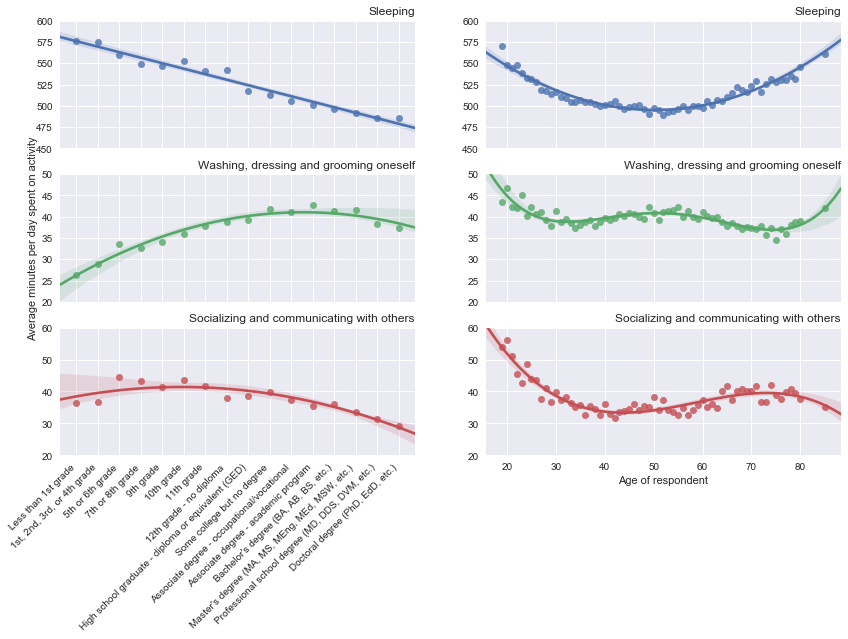

In [445]:
# Regression plots
sns.set_color_codes("deep")
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2,
                                                         sharex='col',
                                                         figsize=(14, 8))

sns.regplot(x='PEEDUCA', y='t010101_W', data=a2, order=1, ax=ax1, color='b')
sns.regplot(x='TEAGE', y='t010101_W', data=a1, order=2, ax=ax2, color='b')
sns.regplot(x='PEEDUCA', y='t010201_W', data=a2, order=2, ax=ax3, color='g')
sns.regplot(x='TEAGE', y='t010201_W', data=a1, order=4, ax=ax4, color='g')
sns.regplot(x='PEEDUCA', y='t120101_W', data=a2, order=2, ax=ax5, color='r')
sns.regplot(x='TEAGE', y='t120101_W', data=a1, order=3, ax=ax6, color='r')

ax1.set(ylim=[450,600], ylabel='', xlabel='')
ax2.set(ylim=[450,600], ylabel='', xlabel='')
ax1.set_title('Sleeping', loc='right')
ax2.set_title('Sleeping', loc='right')

ax3.set(ylim=[20,60], ylabel='Average minutes per day spent on activity', xlabel='')
ax4.set(ylim=[20,60], ylabel='', xlabel='')

ax3.set_title('Washing, dressing and grooming oneself', loc='right')
ax4.set_title('Washing, dressing and grooming oneself', loc='right')

ax5.set(ylim=[20,60], ylabel='', xlabel='', xticks=range(31,47))
ax6.set(ylim=[20,60], ylabel='', xlabel='Age of respondent')
ax5.set_xticklabels(dfeducodes.NAME.values,
                  rotation=45,
                  ha='right')
ax5.set_title('Socializing and communicating with others', loc='right')
ax6.set_title('Socializing and communicating with others', loc='right')

plt.savefig('fig06.svg', bbox_inches='tight')